# Task 6 - Hygiene Prediction
## Summary
Steps to build the hygine prediction model

1. Load the dataset
2. Data cleaning
    * Clean HTML 
    * Unicode using NLTK
    * Word stemming
    * Word lemmatizer
3. Feature selection
    * Explore co-relation between features
    * Choose the features
    * Normalize numeric data
    * Transform text data using TF-IDF vectorizer
4. Evaluate Algorithms
    * Used algorithms
        * LogisticRegression
        * KNeighborsClassifier
        * DecisionTreeClassifier
        * GaussianNB
    * Choose the best algorithm: LogisticRegression
    * Improve Accuracy
        * RandomForestClassifier
        * ExtraTreesClassifier
        * BaggingClassifier
        * GradientBoostingClassifier
        * AdaBoostClassifier
        * GridSearchCV
    * Choose the best tuning model: GridSearchCV
5. Finalize Model
6. Final Result

In [62]:
%load_ext autoreload
%autoreload 2

import glob

import pandas as pd
import numpy as np

# NLP package
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
wordnet_tags = ['n', 'v']

from bs4 import BeautifulSoup

# ML package
from sklearn.feature_extraction.text import CountVectorizer

# Chart packages
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import preprocessing, cross_validation
from sklearn.metrics import f1_score
import scipy as sp

from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

# Disable warning message
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data exploration

In [2]:
df = pd.read_csv('dataset/hygiene.dat.labels', header=None, names=['label'])

In [3]:
def transform(number):
    if number is 1 or number is '1':
        return False
    return True

df['label'] = df.label.apply(transform)

In [4]:
df.head()

,label
0,False
1,False
2,False
3,True
4,True


In [5]:
df_additional = pd.read_csv('dataset/hygiene.dat.additional', header=None, names=['cuisine', 'zipcode', 'count', 'rate'])

In [6]:
df_additional.head()

,cuisine,zipcode,count,rate
0,"['Vietnamese', 'Sandwiches', 'Restaurants']",98118,4,4.000000
1,"['American (New)', 'Restaurants']",98109,21,4.047619
2,"['Mexican', 'Restaurants']",98103,14,3.111111
3,"['Mexican', 'Tex-Mex', 'Restaurants']",98112,42,4.088889
4,"['Mexican', 'Restaurants']",98102,12,3.071429


In [7]:
df_additional.dtypes

cuisine     object
zipcode      int64
count        int64
rate       float64
dtype: object

In [8]:
df_additional.isnull().any()

cuisine    False
zipcode    False
count      False
rate       False
dtype: bool

In [9]:
df_text = pd.read_csv('dataset/hygiene.dat', header=None, names=['text'], sep='delimiter')

In [10]:
df_text.head()

,text
0,"The baguettes and rolls are excellent, and alt..."
1,I live up the street from Betty. &#160;When my...
2,I'm worried about how I will review this place...
3,Why can't you access them on Google street vie...
4,Things to like about this place: homemade guac...


In [11]:
# Join data set
df['text'] = df_text['text']
df['cuisine'] = df_additional['cuisine']
df['zipcode'] = df_additional['zipcode']
df['count'] = df_additional['count']
df['rate'] = df_additional['rate']

In [12]:
df = df.head(546)

In [13]:
def unify_list(text):
    return text.replace("[", "") \
                    .replace("]", "") \
                    .replace("'", "") \
                    .replace(",", "") 
    
df.cuisine = df.cuisine.apply(unify_list)

In [14]:
df.text = df.text.str.lower()

In [15]:
df.head()

,label,text,cuisine,zipcode,count,rate
0,False,"the baguettes and rolls are excellent, and alt...",Vietnamese Sandwiches Restaurants,98118,4,4.000000
1,False,i live up the street from betty. &#160;when my...,American (New) Restaurants,98109,21,4.047619
2,False,i'm worried about how i will review this place...,Mexican Restaurants,98103,14,3.111111
3,True,why can't you access them on google street vie...,Mexican Tex-Mex Restaurants,98112,42,4.088889
4,True,things to like about this place: homemade guac...,Mexican Restaurants,98102,12,3.071429


## 2. Data Cleaning

In [16]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def lemmatize(token, tag):
    if tag[0].lower() in ['n', 'v']:
        return lemmatizer.lemmatize(token, tag[0].lower())
    return token

def clean_text(text):
    tagged = pos_tag(word_tokenize(text))
    lemma = [lemmatize(token, tag) for token, tag in tagged ]
    return ' '.join(lemma)

In [20]:
def remove_html_preprocessor(text):
    return BeautifulSoup(str(text), "lxml").get_text()

In [21]:
df.text = df.text.apply(remove_html_preprocessor)

In [22]:
import unicodedata
def unicode_encode_preprocessor(text):
    return unicodedata.normalize('NFKD', str(text)).encode('ascii','ignore').decode()

In [23]:
df.text = df.text.apply(unicode_encode_preprocessor)

In [24]:
%%time
df.text = df.text.apply(clean_text)

CPU times: user 1min, sys: 917 ms, total: 1min 1s
Wall time: 1min 7s


In [25]:
df.head()

,label,text,cuisine,zipcode,count,rate
0,False,"the baguette and roll be excellent , and altho...",Vietnamese Sandwiches Restaurants,98118,4,4.000000
1,False,i live up the street from betty . when my sist...,American (New) Restaurants,98109,21,4.047619
2,False,i 'm worried about how i will review this plac...,Mexican Restaurants,98103,14,3.111111
3,True,why ca n't you access them on google street vi...,Mexican Tex-Mex Restaurants,98112,42,4.088889
4,True,thing to like about this place : homemade guac...,Mexican Restaurants,98102,12,3.071429


In [26]:
# Write results to a file

In [27]:
df.to_csv('hygiene-clean.csv')

### 3. Feature Selection

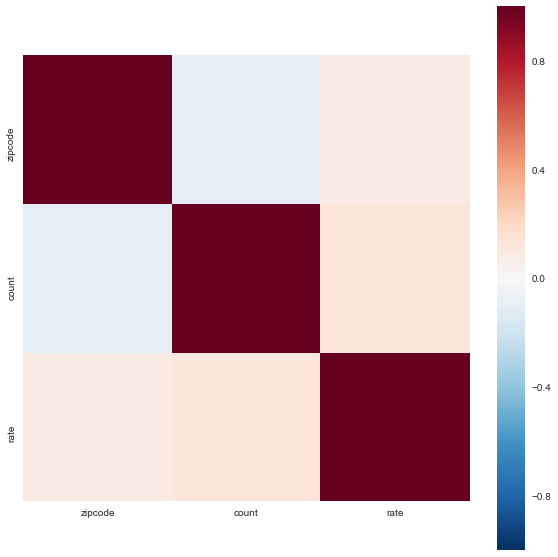

In [28]:
corr = df.select_dtypes(include= ['float64', 'int64']).iloc[:, 0 :].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=1, square=True)

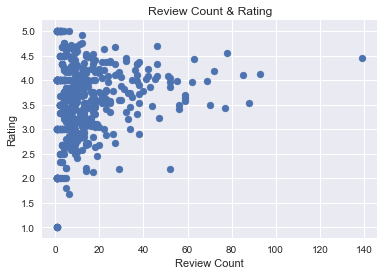

In [29]:
figure = plt.figure()

ax = figure.add_subplot(1, 1, 1)

ax.scatter(df['count'], df['rate'])
plt.title('Review Count & Rating')
plt.xlabel('Review Count')
plt.ylabel('Rating')
plt.show()

In [30]:
df = df.head(500)

In [31]:
df.head()

,label,text,cuisine,zipcode,count,rate
0,False,"the baguette and roll be excellent , and altho...",Vietnamese Sandwiches Restaurants,98118,4,4.000000
1,False,i live up the street from betty . when my sist...,American (New) Restaurants,98109,21,4.047619
2,False,i 'm worried about how i will review this plac...,Mexican Restaurants,98103,14,3.111111
3,True,why ca n't you access them on google street vi...,Mexican Tex-Mex Restaurants,98112,42,4.088889
4,True,thing to like about this place : homemade guac...,Mexican Restaurants,98102,12,3.071429


In [42]:
df.tail()

,label,text,cuisine,zipcode,count,rate
495,False,indian food with no tummyache afterwards ! it ...,Indian Restaurants,98109,7,3.714286
496,False,tickle to find a good breakfast in magnolia - ...,Breakfast & Brunch Greek Restaurants,98199,1,4.000000
497,True,this be the first time i have try this place ....,Breakfast & Brunch Delis Burgers Restaurants,98126,8,3.222222
498,True,after have spend a lifetime go to giant dim su...,Dim Sum Seafood Cantonese Chinese Restaurants,98104,2,3.500000
499,True,pizza be not do properly here . sigh.besides c...,Pizza Italian Fast Food Restaurants,98125,2,2.000000


In [85]:
from sklearn_pandas import DataFrameMapper
train_size = 400
mapper = DataFrameMapper([
    (['count', 'rate'], preprocessing.MinMaxScaler()),
    ('text', TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english'))
])
X_train = mapper.fit_transform(df[:train_size])
X_test = mapper.transform(df[train_size:])
y_train = df[:train_size]['label']
y_test = df[train_size:]['label']

## 4. Evaluate Algorithms
### 4.1 Baseline

In [77]:
seed = 7
num_folds = 10
num_instances = len(X_train)
validation_size = 0.20
scoring = 'f1'

In [78]:
# Spot-Check Algorithms
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))

In [79]:
%%time
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold,
      scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LogisticRegression: 0.625956 (0.068825)
KNeighborsClassifier: 0.576422 (0.083304)
DecisionTreeClassifier: 0.545762 (0.074501)
GaussianNB: 0.459031 (0.077436)
CPU times: user 13.6 s, sys: 913 ms, total: 14.5 s
Wall time: 14.2 s


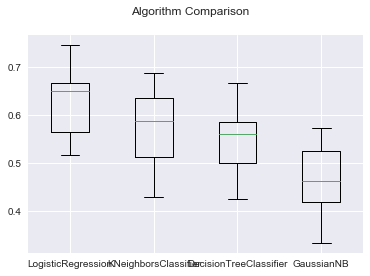

In [80]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### 4.2 Improve Accuracy
#### 4.2.1 Ensembles

In [88]:
%%time
ensembles = []
ensembles.append(( 'RandomForestClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'AB' ,
    RandomForestClassifier())])))
ensembles.append(( 'ExtraTreesClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'GBM' ,
    ExtraTreesClassifier())])))
ensembles.append(( 'BaggingClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'RF' ,
    BaggingClassifier())])))
ensembles.append(( 'GradientBoostingClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'ET' ,
    GradientBoostingClassifier())])))
ensembles.append(( 'AdaBoostClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'ET' ,
    AdaBoostClassifier())])))
results = []
names = []
for name, model in ensembles:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold,
      scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RandomForestClassifier: 0.460690 (0.129746)
ExtraTreesClassifier: 0.502453 (0.074371)
BaggingClassifier: 0.555731 (0.138639)
GradientBoostingClassifier: 0.603897 (0.070557)
AdaBoostClassifier: 0.557914 (0.123253)
CPU times: user 5min 43s, sys: 4.86 s, total: 5min 48s
Wall time: 5min 50s


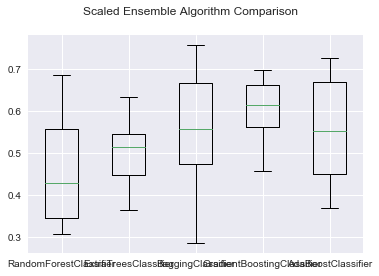

In [89]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( 'Scaled Ensemble Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### 4.2.2 Grid Search Tuning
The score of ensembles are not good enough, we will use Grid Search to tune the result.

In [82]:
pipeline = Pipeline([
   ('clf', LogisticRegression())
])

parameters = {
   'clf__penalty': ('l1', 'l2'),
   'clf__C': (0.01, 0.1, 1, 10),
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1', cv=kfold)
grid_search.fit(X_train, y_train)
print('Best score: %0.3f' % grid_search.best_score_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s


Best score: 0.632


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    8.8s finished


In [86]:
predictions = grid_search.predict(X_test)
print('F1 Score:', f1_score(y_test, predictions))

F1 Score: 0.654545454545


In [92]:
def tuning(model):
    pipeline = Pipeline([
       ('clf', model)
    ])

    parameters = {
       'clf__penalty': ('l1', 'l2'),
       'clf__C': (0.01, 0.1, 1, 10),
    }
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1', cv=kfold)
    grid_search.fit(X_train, y_train)
    print('Best score: %0.3f' % grid_search.best_score_)
    return grid_search

## 5. Finalize Model
### 5.1. Baseline

In [90]:
# prepare the model
model = LogisticRegression(penalty='l2', C=0.3)
model.fit(X_train, y_train)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [91]:
# transform the validation dataset
predictions = model.predict(X_test)
print(f1_score(y_test, predictions))

0.606060606061


### 5.2 Tuning

In [93]:
grid_search = tuning(model)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s


Best score: 0.632


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    9.3s finished


In [95]:
predictions = grid_search.predict(X_test)
print(f1_score(y_test, predictions))

0.654545454545


## 6. Finalize

In [97]:
final_score = f1_score(y_test, predictions)
print('The final F1 score: %0.3f' % final_score)

The final F1 score: 0.655
